# Local-Global-Trend(LGT) Example

In [4]:
import pandas as pd
import numpy as np
from orbit.lgt import LGT
from orbit.utils.utils import plot_predicted_data

## Data

In [5]:
DATA_FILE = "./data/iclaims.example.csv"

In [6]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [7]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

### Data Transformation

In [8]:
df=raw_df.copy()
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log, axis=1)
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


### Train / Test Split

In [9]:
test_size=52
train_df=df[:-test_size]

# in uTS we make assertion that test dates need to be between train start/end
test_df=df[-test_size:]

## MAP Fit and Predict

In [10]:
lgt_map=LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [11]:
lgt_map.fit(df=train_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43e9eb49a3ea13fdcdbe5774911c69d5 NOW.


In [12]:
predicted_df = lgt_map.predict(df=test_df)

In [13]:
predicted_df.head(5)

,week,prediction
0,2017-07-02,12.415366
1,2017-07-09,12.532811
2,2017-07-16,12.374150
3,2017-07-23,12.228283
4,2017-07-30,12.180518


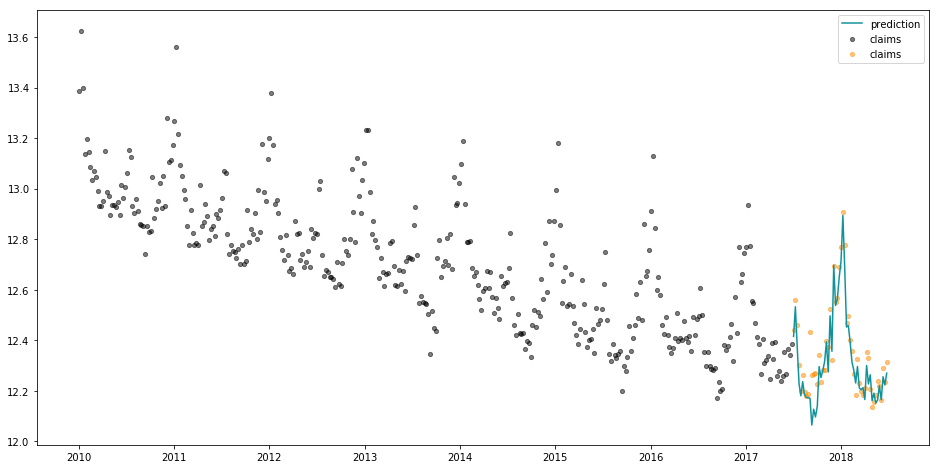

In [14]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MCMC Fit and Predict

In [15]:
lgt_mcmc = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    sample_method='mcmc',
    predict_method='full',
    n_bootstrap_draws=500
)

In [16]:
lgt_mcmc.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [17]:
predicted_df = lgt_mcmc.predict(df=test_df)

In [18]:
predicted_df.tail(5)

,week,5,50,95
47,2018-05-27,12.131350,12.234986,12.341563
48,2018-06-03,12.058382,12.174789,12.285264
49,2018-06-10,12.150537,12.265291,12.387176
50,2018-06-17,12.120982,12.238119,12.353681
51,2018-06-24,12.156339,12.284367,12.399150


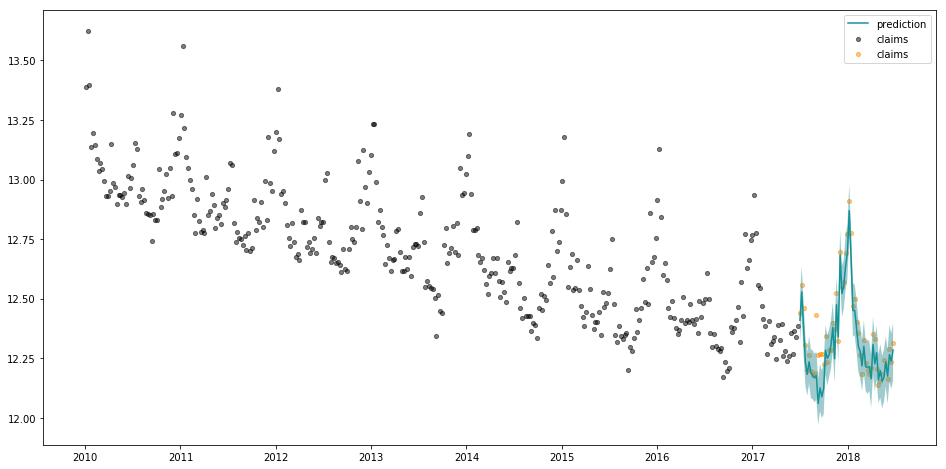

In [19]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_mcmc.date_col, actual_col=lgt_mcmc.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Mean Fit and Predict Decomp

In [20]:
lgt_mean=LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='mean'
)

In [21]:
lgt_mean.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [22]:
predicted_df = lgt_mean.predict(df=test_df, decompose=True)

In [23]:
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.406231,12.483318,-0.077087,0.0
1,2017-07-09,12.522338,12.480494,0.041844,0.0
2,2017-07-16,12.372179,12.478073,-0.105894,0.0
3,2017-07-23,12.225574,12.475805,-0.250231,0.0
4,2017-07-30,12.174846,12.473594,-0.298748,0.0


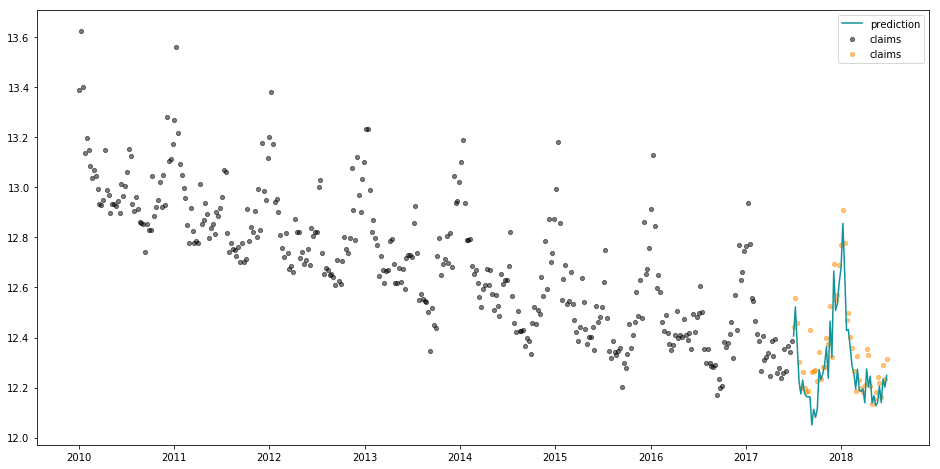

In [24]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_mean.date_col, actual_col=lgt_mean.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MAP Fit and Decomp with Regression

In [25]:
lgt_reg=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [26]:
lgt_reg.fit(df=train_df)

In [27]:
predicted_df = lgt_reg.predict(df=test_df, decompose=True)

In [28]:
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.411768,12.452448,-0.055381,0.014700
1,2017-07-09,12.526122,12.449210,0.066304,0.010608
2,2017-07-16,12.368320,12.447287,-0.089499,0.010532
3,2017-07-23,12.219586,12.445462,-0.232855,0.006978
4,2017-07-30,12.179675,12.443644,-0.273112,0.009143
